In [1]:
import pandas as pd
df = pd.read_excel(r'C:\Users\Edu\Desktop\Definitivo.xlsx', 'KO_ln2', header = 1).set_index('Date')
df

,Ex_rate,FCR,CPI,M1,r,WTI
Date,,,,,,
1994-10-10,NaN,NaN,NaN,NaN,NaN,NaN
1994-11-10,NaN,NaN,NaN,NaN,NaN,NaN
1994-12-10,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-10,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-10,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-05-10,-5.824242,0.503025,-1.002343,14.843449,-140.691365,-1.093670
2020-06-10,-8.950827,1.083768,-0.727207,17.678312,-140.691365,-0.157302
2020-07-10,-4.130320,2.988722,-0.308220,17.182627,-109.861229,-0.043522


In [2]:
df = df.drop(['r'], axis = 1)
df = df.dropna()
df

,Ex_rate,FCR,CPI,M1,WTI
Date,,,,,
2002-12-10,-10.472145,9.758699,0.560035,13.553943,0.772168
2003-01-10,-15.207413,7.289811,1.125972,9.326630,0.673457
2003-02-10,-14.979154,6.568223,1.231765,7.060132,0.900487
2003-03-10,-10.790439,3.607487,2.154123,4.485792,0.688173
2003-04-10,-5.002691,-0.556633,1.224306,4.692547,-0.050512
...,...,...,...,...,...
2020-03-10,-0.502394,-3.402692,0.625926,11.618825,-0.084586
2020-04-10,-0.613450,-1.459434,-0.478345,12.783616,-0.898480
2020-05-10,-5.824242,0.503025,-1.002343,14.843449,-1.093670


In [7]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)

(208, 5)
(4, 5)


In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
          
# ADF Test on each column
        
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Ex_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2776
 No. Lags Chosen       = 12
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0159. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "FCR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7242
 No. Lags Chosen       = 15
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

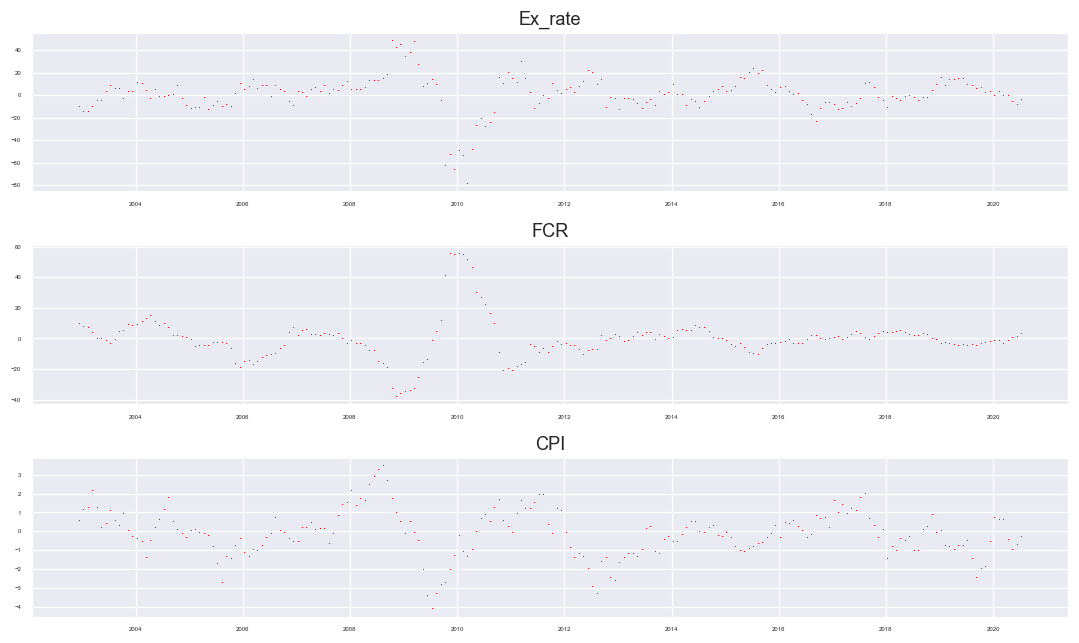

In [75]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=109, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]] #Esto es para que los títulos tengan los mismos nombres que los cabezales
    ax.plot(data, ',', color='red', linewidth=99)
 # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=4)
    
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
#6. Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=14
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
    
grangers_causation_matrix(df, variables = df.columns)

,Ex_rate_x,FCR_x,CPI_x,M1_x,WTI_x
Ex_rate_y,1.000,0.0000,0.0005,0.0000,0.0000
FCR_y,0.000,1.0000,0.0000,0.0000,0.0000
CPI_y,0.001,0.0001,1.0000,0.0012,0.0000
M1_y,0.000,0.0143,0.0004,1.0000,0.0095
WTI_y,0.000,0.0000,0.0009,0.0008,1.0000


In [10]:
#Es muy interesante esto que hemos encontrado de las endógenas y exógenas
#Tal vez deberiamos incluir WTI en el grupo de endógenas
#saber como se pone la frecuencia queda pendiente
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
model = VAR(endog=df[['Ex_rate','WTI']],exog=df[['FCR','CPI','WTI','M1']],freq=None)

C:\Users\Edu\anaconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [11]:
#fit([maxlags, method, ic, trend, verbose])
results = model.fit(maxlags=None,method='ols',ic='hqic',trend='nc',verbose=True)
results.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC -> 1>
Using 1 based on hqic criterion


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, Oct, 2020
Time:                     01:32:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -64.5477
Nobs:                     211.000    HQIC:                  -64.6612
Log likelihood:           6243.10    FPE:                7.66537e-29
AIC:                     -64.7383    Det(Omega_mle):     7.24734e-29
--------------------------------------------------------------------
Results for equation Ex_rate
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
FCR               -0.519603         0.064250           -8.087           0.000
CPI                1.731613         0.527396            3.283           0.001
WTI               -5.766188         2.232921           -2.582         

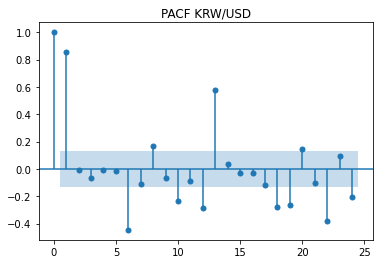

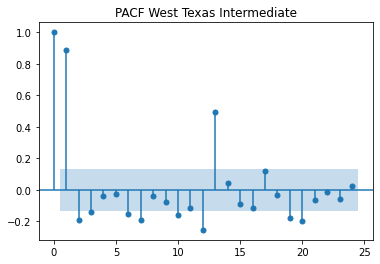

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(df['Ex_rate'],title='PACF KRW/USD')
plot_pacf(df['WTI'],title='PACF West Texas Intermediate')

plt.show()

In [13]:
#Que criterio es mejor usar para mi modelo????

x = model.select_order(maxlags=15)
x.summary()

,AIC,BIC,FPE,HQIC
0,-63.83,-63.67,1.896e-28,-63.76
1,-66.59*,-66.36*,1.201e-29*,-66.50*
2,-63.91,-63.61,1.749e-28,-63.79
3,-62.89,-62.52,4.881e-28,-62.74
4,-62.93,-62.50,4.673e-28,-62.76
5,-62.72,-62.22,5.758e-28,-62.52
6,-62.72,-62.15,5.764e-28,-62.49
7,-62.39,-61.76,8.011e-28,-62.14
8,-62.81,-62.11,5.305e-28,-62.52
9,-62.21,-61.45,9.610e-28,-61.90


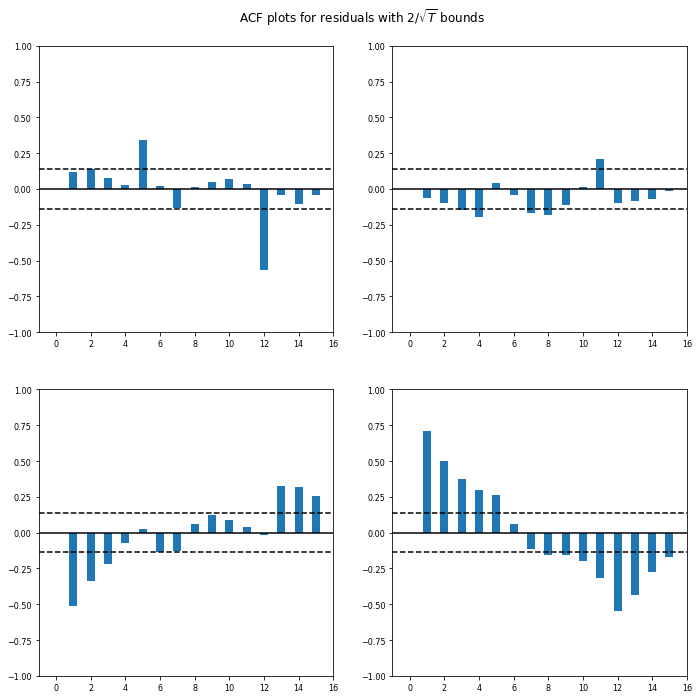

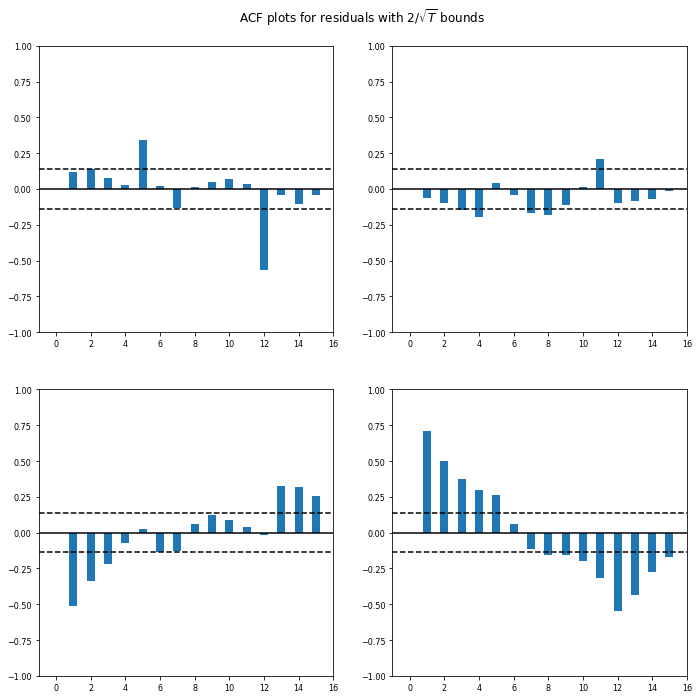

In [14]:
results.plot_acorr(15)

In [36]:
residuos = results.test_whiteness(nlags=3, signif=0.05, adjusted=True)
residuos.summary()

Test statistic,Critical value,p-value,df
656.6,21.03,0.000,12


In [37]:
normalidad = results.test_normality()
normalidad.summary()

Test statistic,Critical value,p-value,df
34.28,9.488,0.000,4


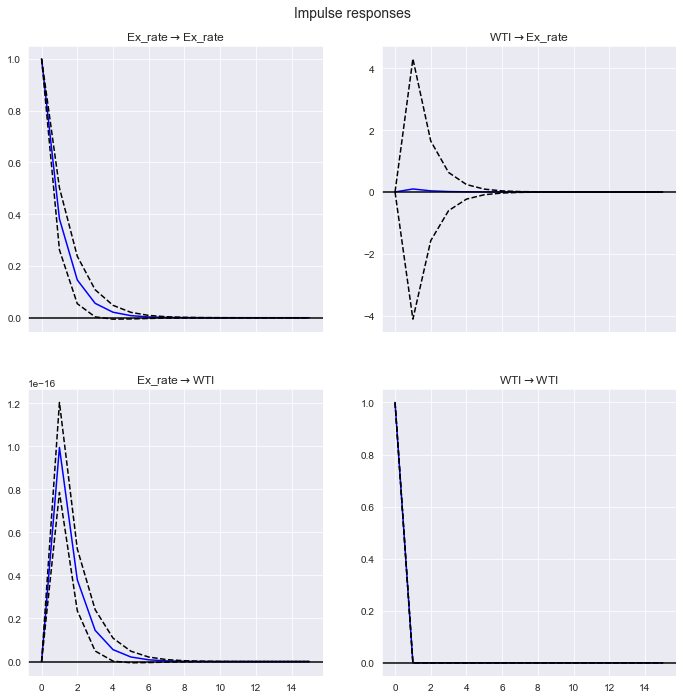

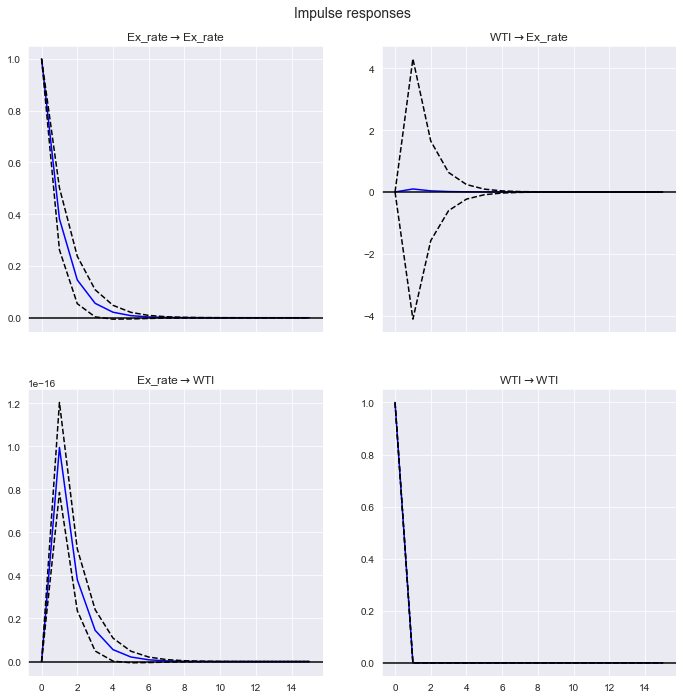

In [15]:
#Esto es simplemente para que el estilo del gráfico sea seaborn ( esto le dará uniformidad al paper)
import seaborn as sns
sns.set_style("darkgrid")
irf = results.irf(15)
irf.plot(orth=False)

In [16]:
model2 = VAR(endog=df[['Ex_rate','WTI']],exog=df[['FCR','CPI','WTI']],freq=None)

C:\Users\Edu\anaconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [17]:
#fit([maxlags, method, ic, trend, verbose])
results2 = model2.fit(maxlags=None,method='ols',ic='hqic',trend='nc',verbose=True)
results2.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC -> 1>
Using 1 based on hqic criterion


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, Oct, 2020
Time:                     01:37:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -67.5644
Nobs:                     211.000    HQIC:                  -67.6590
Log likelihood:           6556.01    FPE:                3.87430e-30
AIC:                     -67.7232    Det(Omega_mle):     3.69701e-30
--------------------------------------------------------------------
Results for equation Ex_rate
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
FCR               -0.520673         0.064057           -8.128           0.000
CPI                1.727205         0.526178            3.283           0.001
WTI               -5.695043         2.220584           -2.565         

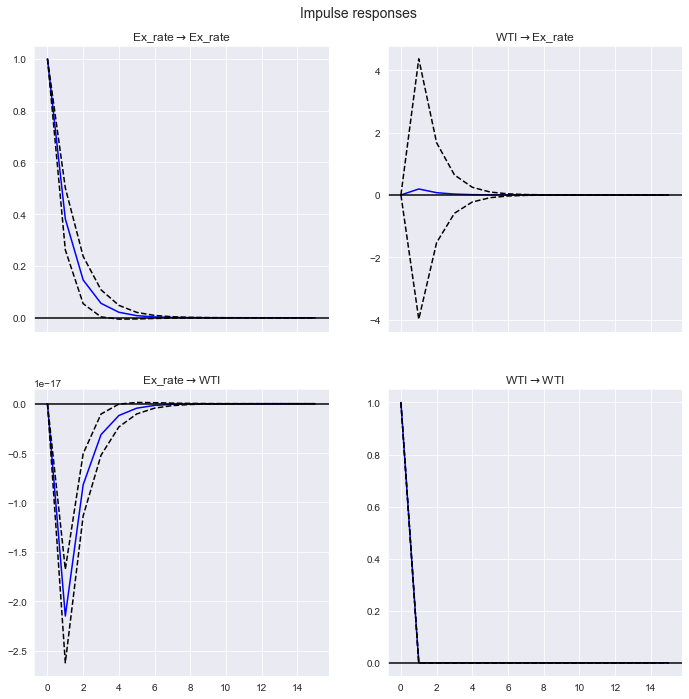

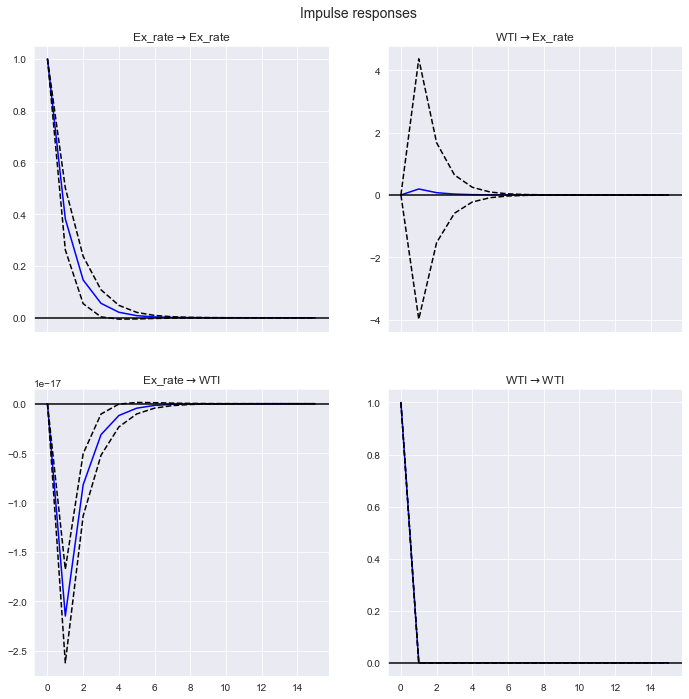

In [18]:
#Esto es simplemente para que el estilo del gráfico sea seaborn ( esto le dará uniformidad al paper)
import seaborn as sns
sns.set_style("darkgrid")
irf2 = results2.irf(15)
irf2.plot(orth=False)

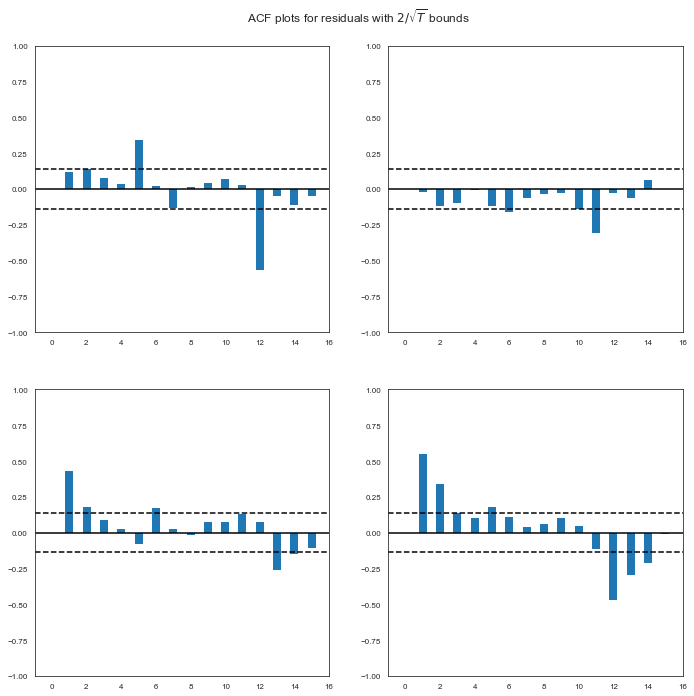

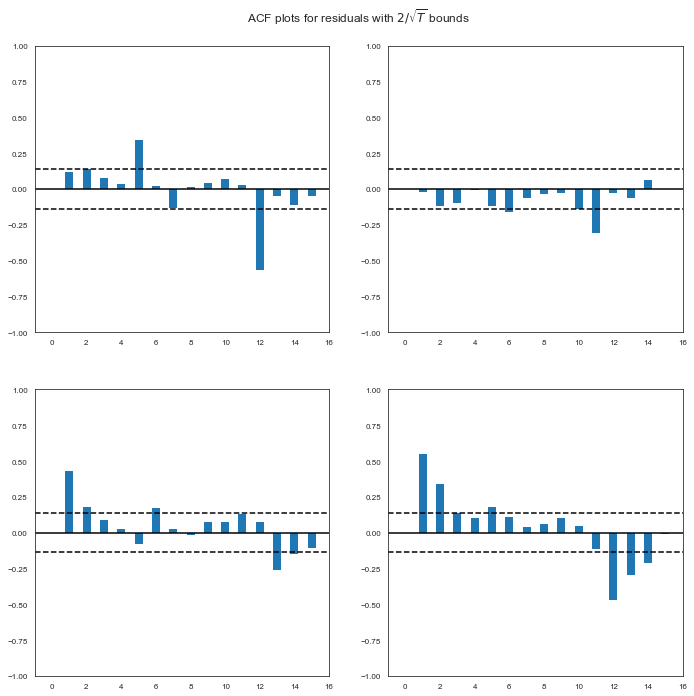

In [19]:
sns.set_style("white")
results2.plot_acorr(15)

In [20]:
#Que criterio es mejor usar para mi modelo????

x = model.select_order(maxlags=15)
x.summary()

,AIC,BIC,FPE,HQIC
0,-63.83,-63.67,1.896e-28,-63.76
1,-66.59*,-66.36*,1.201e-29*,-66.50*
2,-63.91,-63.61,1.749e-28,-63.79
3,-62.89,-62.52,4.881e-28,-62.74
4,-62.93,-62.50,4.673e-28,-62.76
5,-62.72,-62.22,5.758e-28,-62.52
6,-62.72,-62.15,5.764e-28,-62.49
7,-62.39,-61.76,8.011e-28,-62.14
8,-62.81,-62.11,5.305e-28,-62.52
9,-62.21,-61.45,9.610e-28,-61.90
